# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "leo"
ln1 = "treguer"
fn2 = "mehdi"
ln2 = "miah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_treguer_leo_and_miah_mehdi.ipynb


In [3]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

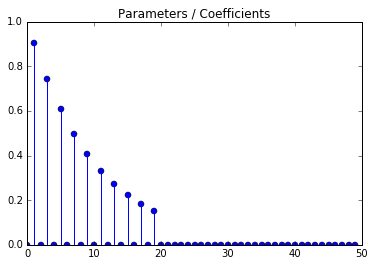

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

Each coefficient is a positive number. This remark leads to the application of the indicator function of $\mathbb{R}_+$.

### Functions for the simulation of the models

In [6]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

### Question 1/5 : 
Code a function that computes $g(x)$ and $\text{prox}_g(x)$ in both cases

#### Case when g is the Lasso penalization

In [7]:
def lasso(x,s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm(x, ord=1)

def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.sign(x) * np.maximum(np.abs(x) - s*t,0)


We get the same code as in the previous TP.

#### Case when g is the indicator function

In [8]:
import math

def indicator(x,s):
    """Value of the indicator penalization at x"""
    minimum = np.min(x)
    if minimum < 0:
        res = math.inf
    else:
        res = 0
    return res

def prox_indicator(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.maximum(x, 0)


Indeed, the indicator is equal to 0 when each coefficient equals 0, otherwise, the indicator is $+\infty$.
As for the proximal, we can notice that due to the previous remark, the return value must be the closest of $x$ and each of its component has to be positive. Hence, the return parameter is the maximum between $x$ and 0 (element-wise).

Plot of the proximal operators


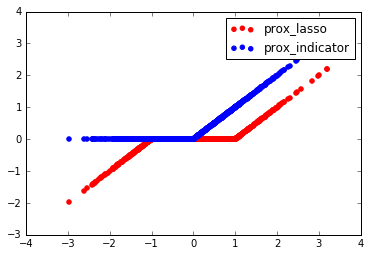

In [9]:
x = randn(1000)

x_barlasso = prox_lasso(x, 0.5, 2)
x_barindic=prox_indicator(x,0.5,2)
plasso=plt.scatter(x = x, y = x_barlasso,color='red',label='prox_lasso')
pindic=plt.scatter(x=x,y=x_barindic,color='blue',label="prox_indicator")

plt.legend(handles=[plasso,pindic])

plt.show()

Influence on coefficients

(-2, 2)

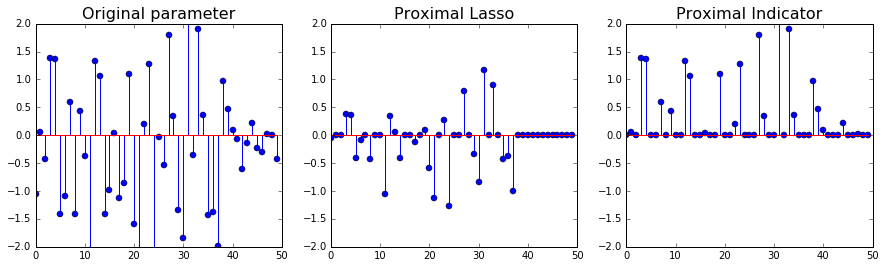

In [10]:
x = randn(50)
l_l1 = 1.
l_l2 = 2

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1,t=1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_indicator(x, s=l_l2,t=1))
plt.title("Proximal Indicator", fontsize=16)
plt.ylim([-2, 2])

We notice that the coefficents given by the proximal indicator are positive or equal to 0.

Regarding the lasso regularization, the proximal operator is the following: $\text{sign}(x)(|x|-\lambda)_{+}$. Thus, the coefficients between $-\lambda$ and $+\lambda$ are shrinked to zero, while the others are decreased by the constant scalar $\lambda$. This is what we see here.


### Question 2/5 
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

We consider $F(x)=\frac{1}{2} \|b - Ax\|^2 + g(x)=f(x)+g(x)$

The f function is convex and diffentiable.

The g function is convex in both the lasso regularization and for the indicator function of $\mathbb{R}_+$

### Question 3/5 
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.

In [11]:
def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    #computing all the values of the denominator
    #We compute the denominator outside the for loop for optim
        
    denum_i = [np.dot(A[:,i], A[:,i]) for i in range(n_features)]
        
    for k in range(n_iter + 1):

        #modulo
        i = k % n_features
        
        #We implement the smart residuals update
        r = b - np.dot(A,x)
        ai = A[:,i]
        num = np.dot(ai, r)
        denum = denum_i[i]
        
        #update
        x[i] += prox_g(num/denum, s)   
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
                 )
    return x, objectives, np.array(errors)

In [12]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 100
s = 1e-1

#Generating A and b
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

#Proximal coordinate descent with Indicator function
print("Proximal coordinate descent with Indicator function")
x_ind, obj_ind,err_ind = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter, x_true=coefs, verbose=True)

#Proximal coordinate descent with the Lasso function
print("\n Proximal coordinate descent with the Lasso function")
x_lasso, obj_lasso,err_lasso = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=True)


Proximal coordinate descent with Indicator function
Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.29e+03 | 1.07e+00
      10 | 1.12e+03 | 6.35e-01
      20 | 9.83e+02 | 5.55e-01
      30 | 9.77e+02 | 5.60e-01
      40 | 9.75e+02 | 5.62e-01
      50 | 9.72e+02 | 5.63e-01
      60 | 9.72e+02 | 5.63e-01
      70 | 9.72e+02 | 5.63e-01
      80 | 9.72e+02 | 5.63e-01
      90 | 9.72e+02 | 5.63e-01
     100 | 9.72e+02 | 5.63e-01

 Proximal coordinate descent with the Lasso function
Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.29e+03 | 1.05e+00
      10 | 9.40e+02 | 5.70e-01
      20 | 7.60e+02 | 4.80e-01
      30 | 7.60e+02 | 4.80e-01
      40 | 7.60e+02 | 4.80e-01
      50 | 6.25e+02 | 3.64e-01
      60 | 5.33e+02 | 2.47e-01
      70 | 5.33e+02 | 2.46e-01
      80 | 5.33e+02 | 2.46e-01
      90 | 5.33e+02 | 2.46e-01
     100 | 5.33e+02 | 2.46e-01


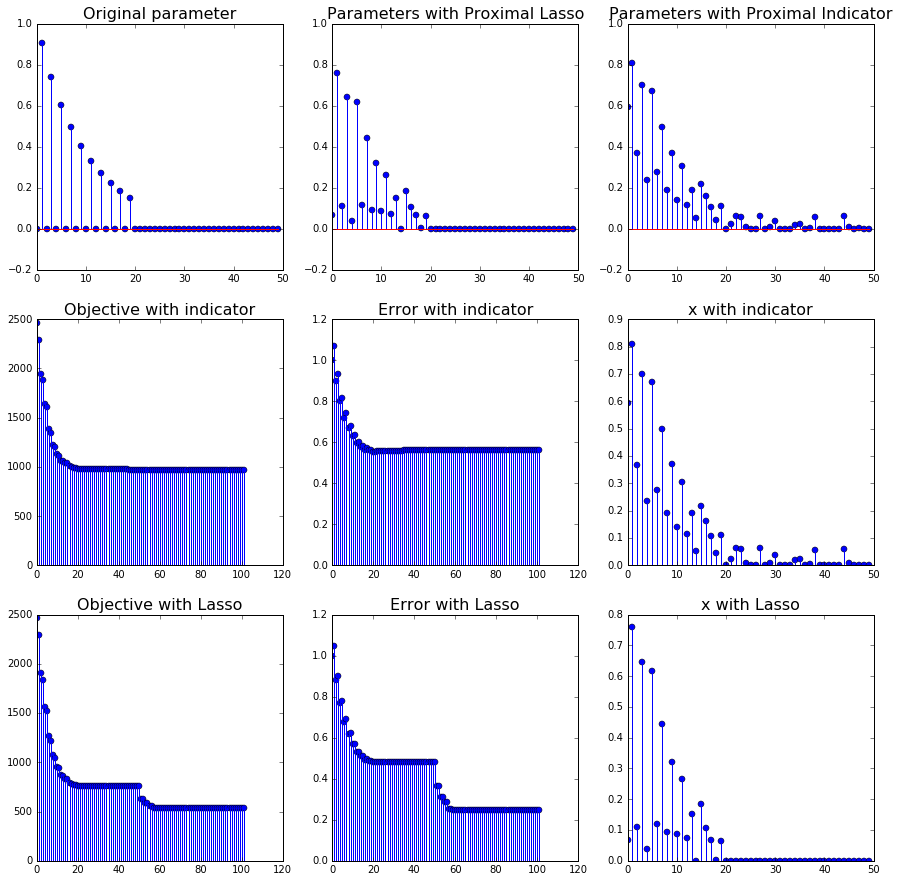

In [13]:
plt.figure(figsize=(15.0, 15.0))

plt.subplot(3, 3, 1)
plt.stem(coefs)
plt.title("Original parameter", fontsize=16)
plt.ylim([-0.2, 1])

plt.subplot(3, 3, 2)
plt.stem(x_lasso)
plt.title("Parameters with Proximal Lasso", fontsize=16)
plt.ylim([-0.2, 1])

plt.subplot(3, 3, 3)
plt.stem(x_ind)
plt.title("Parameters with Proximal Indicator", fontsize=16)
plt.ylim([-0.2, 1])

plt.subplot(3, 3, 4)
plt.stem(obj_ind)
plt.title("Objective with indicator", fontsize=16)

plt.subplot(3, 3, 5)
plt.stem(err_ind)
plt.title("Error with indicator", fontsize=16)

plt.subplot(3, 3, 6)
plt.stem(x_ind)
plt.title("x with indicator", fontsize=16)

plt.subplot(3, 3, 7)
plt.stem(obj_lasso)
plt.title("Objective with Lasso", fontsize=16)

plt.subplot(3, 3, 8)
plt.stem(err_lasso)
plt.title("Error with Lasso", fontsize=16)

plt.subplot(3, 3, 9)
plt.stem(x_lasso)
plt.title("x with Lasso", fontsize=16)

Regarding the parameters, we notice that the convergence is faster with the lasso function than with the indicator function, as all the coefficients computed with the lasso function are equal to 0, after the 20th parameter (as for the original parameters).

Regarding the objective, we notice that the convergence has a "stairs" shape for both functions, and is about the same speed. There is a "bump" at the 50th iteration for the objective with the lasso function, which is explained by the fact that there are 50 parameters to compute.

Regarding the error, we notice the same "stairs"-shaped convergence and the same "bump" around the 50th iteration for the lasso function. The error is smaller with the lasso function.

### Question 4/5
- Evaluate qualitatively the convergence when varying the conditioning of the problem.

We can evaluate the determinant of $A^TA$ as a function of the correlation term in $A$.

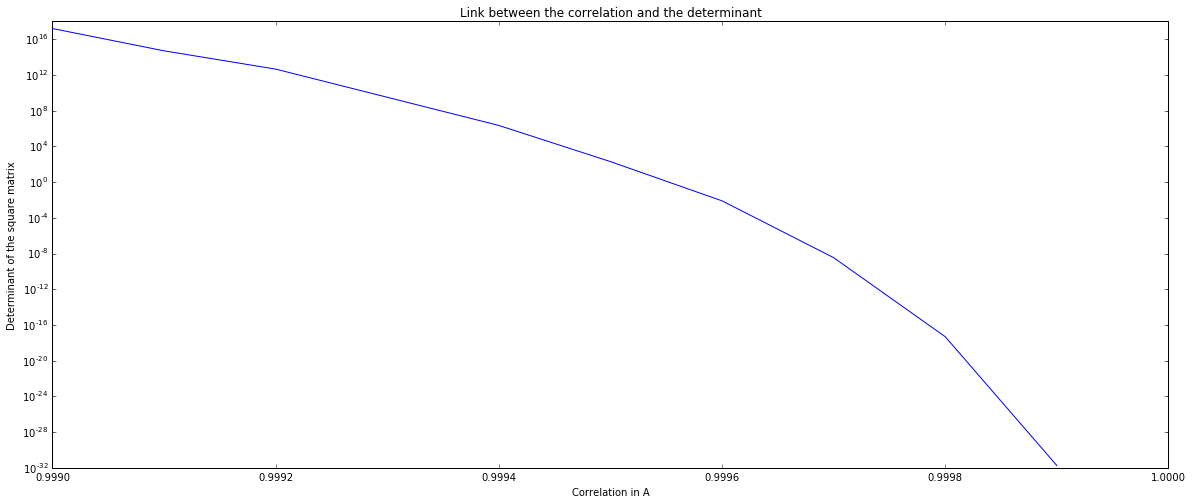

In [14]:
corr_x = 0.999+ np.arange(10)/10000
determinant = list()

for i in range(len(corr_x)):
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])
    det = np.linalg.det(np.dot(np.transpose(A), A))
    determinant.append(det)

plt.figure(figsize=(20.0, 8.0))
plt.semilogy(corr_x, determinant)
plt.xlabel('Correlation in A')
plt.ylabel('Determinant of the square matrix')
plt.title('Link between the correlation and the determinant')

We observe that the greater the correlation is in A, the lower the determinant of $A^TA$ is. Therefore, this square matrix is no longer invertible. Moreover, the condition number is proportional to the determinant of $A^TA$. 

In [15]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-1

corr_x = 0+ np.arange(10)/10
err_corr = []

#For each value of corr, we compute a linear regression in order to compare the error
for i in range(len(corr_x)):

    #Generating A and b
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])

    #Test with the Lasso function
    x_lasso, obj_lasso,err_lasso = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=False)
    
    #Collect error
    err_corr.append(err_lasso)

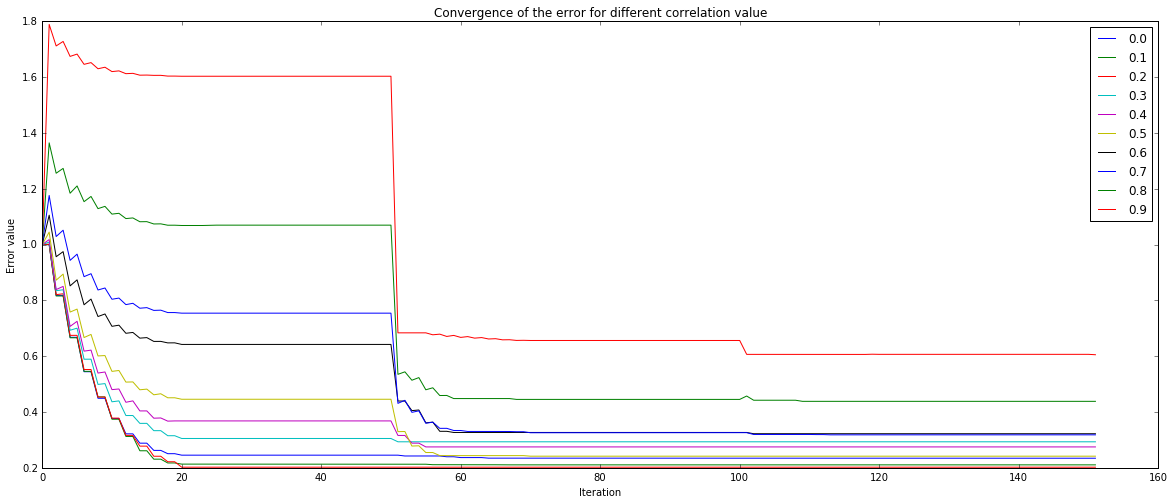

In [16]:
plt.figure(figsize=(20.0, 8.0))

for i in range(len(corr_x)):

    plt.plot(err_corr[i], label = corr_x[i])
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Error value')
    plt.title('Convergence of the error for different correlation value')

From the graph above, it appears that the greater the correlation in $A$ is, the slowest the convergence is. Moreover, the error term is greater when the correlation increases. That means that the convergence is slow when the problem is bad conditioning.

### Question 5/5 (bonus)

- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

We will reuse the code from the TP1 : 

In [17]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.sign(x) * np.maximum(np.abs(x) - s*t,0)
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s * np.linalg.norm(x, ord=1)

def loss_linreg(x):
    """Least-squares loss"""
    n = len(x)
    res = 1/(2*n) * np.linalg.norm(b-np.dot(A,x), ord=2)**2
    return(res)

def grad_linreg(x):
    """Leas-squares gradient"""
    n = len(x)
    res = 1/n * np.dot(np.transpose(A),np.dot(A,x)-b)
    return(res)

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    res = np.linalg.norm(np.dot(np.transpose(A),A), ord = 2)/len(A[1,])
    return(res)

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s, step)

        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
            )
    return x, objectives, errors

In [36]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 50
s = 1e-2

corr_x = 0.97+ np.arange(3)/100
err_corr_cd = []
err_corr_pgd = []

# For each value of corr, we compute a linear regression with proximal gradient descent and proximal coordinate descent
# We keep the same Lasso penalisation
for i in range(len(corr_x)):

    #Generating A and b
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])

    #Test with the Lasso function, descent coordinate
    x_cd, obj_cd,err_cd = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=False)
    
    #Test with the Lasso function, proximal descent gradient
    step = 1/lip_linreg(A)
    x_pgd, obj_pgd,err_pgd = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter,x_true=coefs, verbose=False)
    
    #Collect error
    err_corr_cd.append(err_cd)
    err_corr_pgd.append(err_pgd)

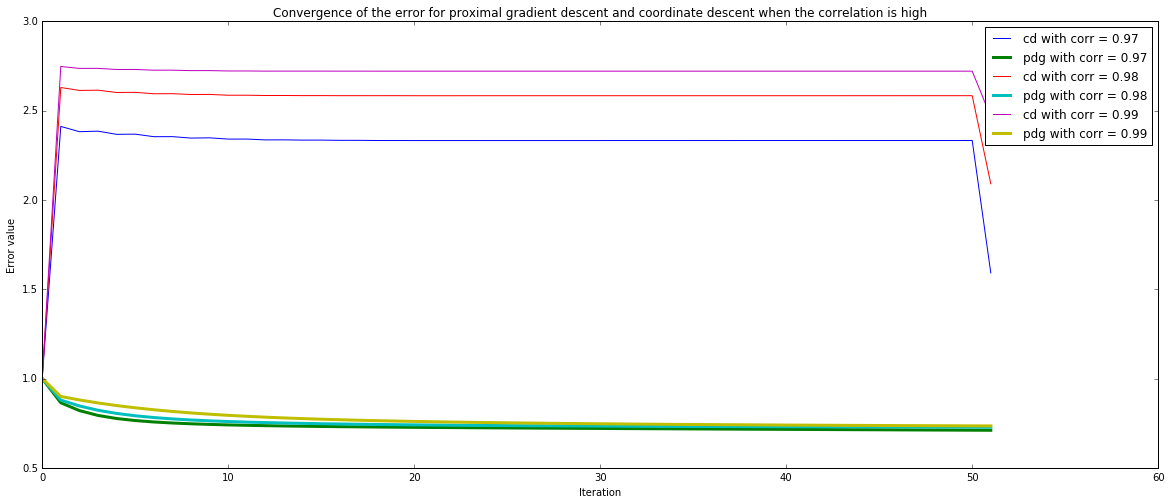

In [37]:
plt.figure(figsize=(20.0, 8.0))

for i in range(len(corr_x)):

    plt.plot(err_corr_cd[i], label = "cd with corr = " + str(corr_x[i]))
    plt.plot(err_corr_pgd[i], label = "pdg with corr = " + str(corr_x[i]), linewidth=3.0)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Error value')
    plt.title('Convergence of the error for proximal gradient descent and coordinate descent when the correlation is high')

When the correlation in $A$ is high, we notice that the error term follows a step function : only one coordinate seems relevant in the optimisation. The others affect less the error term.

From then on, when we consider the 50 first iteration, proximal gradient descent converges fastly to the minimum, whereas, we have to wait the $50^{th}$ iteration in proximal coordinate descent to have a progress in the error term.

Moreover, a little difference of the correlation leds to a bigger difference in the error term.